# Phase 4 Project

## Business Objective

To help Acme Online analyze customer tweets from their Twitter page about Apple and Google products. The result of this analysis will be used to find out which company's product or service is more popular - This will help Acme Online tweak their portfolio accordingly.

## Methodology

1. Analyze the tweets to see check what sort of emotion we can detect about a company's product/service. For eg: if we're talking about an iPad, we can analyze tweets about iPads to see if they're positive, negative or neutral. We can extraploate this to different product categories and gage sentiment of each.

2. We can analyze the tweets to see what customers are tweeting about i.e. are they tweeting more about Apple products/service or Google products/services? This can be used to gage semtiment of the brand itself i.e Apple and Google.



# Dataset

Dataset sourced from CrowdFlower via data.world: https://data.world/crowdflower/brands-and-product-emotions

# Analysis

In [1]:
#import relevant libraries
import pandas as pd

In [2]:
df= pd.read_csv('tweets.csv',encoding = 'unicode_escape')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
#renaming the columns to make it less cumbersome
df.rename(columns={'emotion_in_tweet_is_directed_at':'product_service',
                   'is_there_an_emotion_directed_at_a_brand_or_product':'emotion'},inplace=True)
df.head()

,tweet_text,product_service,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
#getting some info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_text       9092 non-null   object
 1   product_service  3291 non-null   object
 2   emotion          9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [5]:
#checking for null values
df.isna().sum()

tweet_text            1
product_service    5802
emotion               0
dtype: int64

We can see that the `product_service` column has a large number of missing values; more than 50%

In [6]:
#examining the product_service column
df['product_service'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: product_service, dtype: int64

In [11]:
#let's group product/services that resemble each other for both brands. This will make for easier analysis

df['product_service'].replace('Other Google product or service','Google',inplace=True)
df['product_service'].replace('Other Apple product or service','Apple',inplace=True)
df['product_service'].replace('Android App','Android',inplace=True)

In [13]:
#checking
df['product_service'].value_counts()

iPad                  946
Google                723
Apple                 696
iPad or iPhone App    470
iPhone                297
Android               159
Name: product_service, dtype: int64

In [185]:
df['product_service'].fillna('missing',inplace=True)

In [186]:
df['product_service'].value_counts()

missing               5802
iPad                   946
Google                 723
Apple                  696
iPad or iPhone App     470
iPhone                 297
Android                159
Name: product_service, dtype: int64

In [189]:
df[df['product_service']=='missing']

,tweet_text,product_service,emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,missing,No emotion toward brand or product
6,NaN,missing,No emotion toward brand or product
16,Holler Gram for iPad on the iTunes App Store -...,missing,No emotion toward brand or product
32,"Attn: All #SXSW frineds, @mention Register fo...",missing,No emotion toward brand or product
33,Anyone at #sxsw want to sell their old iPad?,missing,No emotion toward brand or product
...,...,...,...
9087,"@mention Yup, but I don't have a third app yet...",missing,No emotion toward brand or product
9089,"Wave, buzz... RT @mention We interrupt your re...",missing,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",missing,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,missing,No emotion toward brand or product


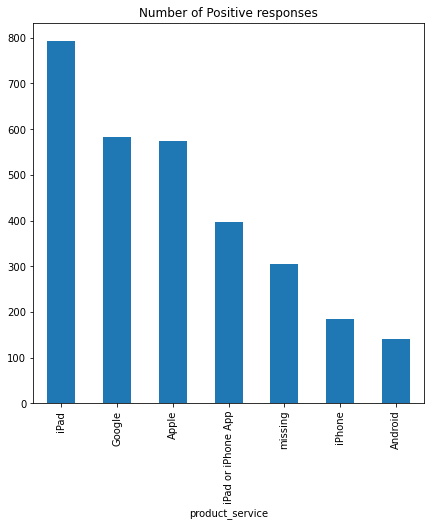

In [187]:
#filtering out positive emotions
positive = df[df['emotion']== 'Positive emotion']


#plotting a graph to see which product_service elicits the most positive responses
pos_df = positive.groupby('product_service').count()
pos_df.sort_values('emotion',ascending=False,inplace=True)
pos_df.plot(y='emotion',kind='bar',legend=False,figsize=(7,7),title='Number of Positive responses');

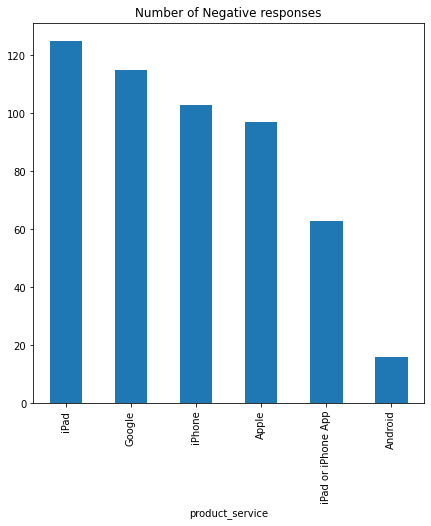

In [157]:
#filtering out negative emotions
negative = df[df['emotion']== 'Negative emotion']


#plotting a graph to see which product_service elicits the most positive responses
neg_df = negative.groupby('product_service').count()
neg_df.sort_values('emotion',ascending=False,inplace=True)
neg_df.plot(y='emotion',kind='bar',legend=False,figsize=(7,7),title='Number of Negative responses');

create new dfs for each product_Service and see if you can emotional count side by side for each